In [15]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# --- 1. Llegir tots els CSV locals ---
data_path = Path("/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/") / "*.csv"

df = pl.scan_csv(str(data_path))

In [10]:
# --- 2. Crear timestamp correcte ---
df = df.with_columns(
    pl.col("data")
      .cast(pl.Utf8)  # passa d'enter a text
      .str.strptime(pl.Datetime, format="%Y%m%d%H%M%S")
      .alias("timestamp")
)

In [16]:
df = pl.read_parquet("dataset_1y.parquet")

daily = (
    df
    .with_columns(pl.col("timestamp").dt.truncate("1d").alias("day"))
    .group_by("day")
    .agg([
        (pl.col("estatActual").is_in([1,2,3,4,5]).mean() * 100).alias("pct_useful"),
        (pl.col("estatActual").is_in([0,6]).mean() * 100).alias("pct_missing")
    ])
    .sort("day")
)

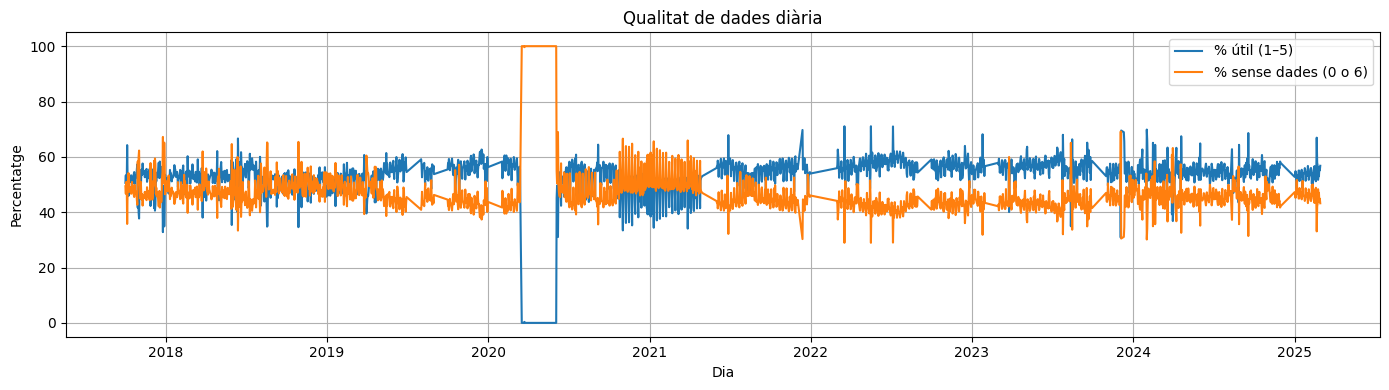

In [12]:
plt.figure(figsize=(14,4))
plt.plot(daily["day"], daily["pct_useful"], label="% útil (1–5)")
plt.plot(daily["day"], daily["pct_missing"], label="% sense dades (0 o 6)")
plt.ylabel("Percentatge")
plt.xlabel("Dia")
plt.title("Qualitat de dades diària")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
monthly = (
    daily.with_columns(daily["day"].dt.strftime("%Y-%m").alias("month"))
         .group_by("month")
         .mean()
         .sort("month")
)
print(monthly.sort("pct_useful", descending=True).head(10))

shape: (10, 4)
┌─────────┬─────────────────────┬────────────┬─────────────┐
│ month   ┆ day                 ┆ pct_useful ┆ pct_missing │
│ ---     ┆ ---                 ┆ ---        ┆ ---         │
│ str     ┆ datetime[μs]        ┆ f64        ┆ f64         │
╞═════════╪═════════════════════╪════════════╪═════════════╡
│ 2022-07 ┆ 2022-07-16 00:00:00 ┆ 59.820993  ┆ 40.179007   │
│ 2023-07 ┆ 2023-07-16 00:00:00 ┆ 58.619813  ┆ 41.380187   │
│ 2022-06 ┆ 2022-06-15 12:00:00 ┆ 58.573392  ┆ 41.426608   │
│ 2022-05 ┆ 2022-05-16 00:00:00 ┆ 57.84077   ┆ 42.15923    │
│ 2023-09 ┆ 2023-09-15 12:00:00 ┆ 57.406736  ┆ 42.593264   │
│ 2022-11 ┆ 2022-11-15 12:00:00 ┆ 57.401063  ┆ 42.598937   │
│ 2020-02 ┆ 2020-02-15 00:00:00 ┆ 57.370561  ┆ 42.629439   │
│ 2023-06 ┆ 2023-06-15 12:00:00 ┆ 57.193365  ┆ 42.806635   │
│ 2019-12 ┆ 2019-12-16 00:00:00 ┆ 57.100194  ┆ 42.899806   │
│ 2023-05 ┆ 2023-05-16 00:00:00 ┆ 57.047086  ┆ 42.952914   │
└─────────┴─────────────────────┴────────────┴─────────────┘


In [24]:
# -- 1. Definim els límits de temps
start_2y = pl.datetime(2022, 11, 1)   # 1 novembre 2022
end_2y   = pl.datetime(2024, 10, 31)  # 31 octubre 2024

start_1y = pl.datetime(2023, 11, 1)   # 1 novembre 2023
end_1y   = end_2y                     # mateix final

# Filtrar i col·leccionar
dataset_2y = (
    df.filter((pl.col("timestamp") >= start_2y) & (pl.col("timestamp") <= end_2y))
      .collect()          # <- materialitza a DataFrame
)
dataset_1y = (
    df.filter((pl.col("timestamp") >= start_1y) & (pl.col("timestamp") <= end_1y))
      .collect()
)

# Desa en Parquet
dataset_2y.write_parquet("dataset_2y.parquet")
dataset_1y.write_parquet("dataset_1y.parquet")

In [19]:
df = pl.read_parquet("dataset_1y.parquet")

daily = (
    df
    .with_columns(pl.col("timestamp").dt.truncate("1d").alias("hour"))
    .group_by("hour")
    .agg([
        (pl.col("estatActual").is_in([1,2,3,4,5]).mean() * 100).alias("pct_useful"),
        (pl.col("estatActual").is_in([0,6]).mean() * 100).alias("pct_missing")
    ])
    .sort("hour")
)

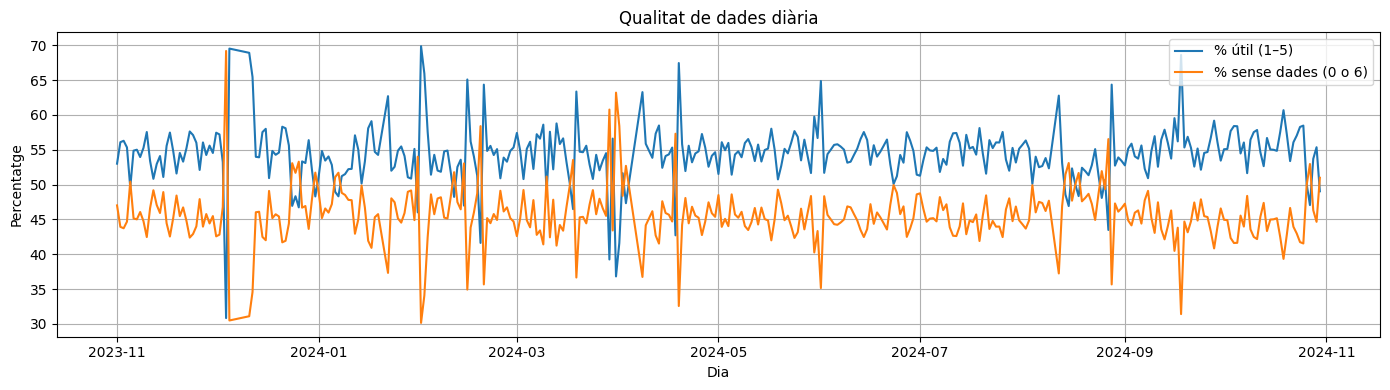

In [20]:
plt.figure(figsize=(14,4))
plt.plot(daily["hour"], daily["pct_useful"], label="% útil (1–5)")
plt.plot(daily["hour"], daily["pct_missing"], label="% sense dades (0 o 6)")
plt.ylabel("Percentatge")
plt.xlabel("Dia")
plt.title("Qualitat de dades diària")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
import polars as pl

df = pl.read_parquet("dataset_1y.parquet")

# Conjunt global de timestamps esperats
n_total_ts = df["timestamp"].n_unique()

coverage = (
    df.group_by("idTram")
      .agg(pl.col("timestamp").n_unique().alias("n_ts"))
      .with_columns([
          (pl.lit(n_total_ts) - pl.col("n_ts")).alias("missing_count"),
          (pl.col("n_ts") / n_total_ts * 100).alias("coverage_pct")
      ])
      .sort("coverage_pct")
)

print(coverage)   # trams amb menys cobertura primer


shape: (532, 4)
┌────────┬───────┬───────────────┬──────────────┐
│ idTram ┆ n_ts  ┆ missing_count ┆ coverage_pct │
│ ---    ┆ ---   ┆ ---           ┆ ---          │
│ i64    ┆ u32   ┆ u32           ┆ f64          │
╞════════╪═══════╪═══════════════╪══════════════╡
│ 18     ┆ 47942 ┆ 0             ┆ 100.0        │
│ 402    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 33     ┆ 47942 ┆ 0             ┆ 100.0        │
│ 298    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 277    ┆ 47942 ┆ 0             ┆ 100.0        │
│ …      ┆ …     ┆ …             ┆ …            │
│ 485    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 253    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 244    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 128    ┆ 47942 ┆ 0             ┆ 100.0        │
│ 503    ┆ 47942 ┆ 0             ┆ 100.0        │
└────────┴───────┴───────────────┴──────────────┘


In [8]:
import polars as pl

df = (
    pl.read_parquet("dataset_1y.parquet")
    .select(["idTram", "timestamp"])
    .sort(["idTram", "timestamp"])
    .with_columns(
        (pl.col("timestamp") - pl.col("timestamp").shift(1))
        .over("idTram")
        .alias("delta")
    )
)

# salts > 6 min per afegir una mica de marge
gaps = (
    df.filter(pl.col("delta") > pl.duration(minutes=6))
      .with_columns([
          pl.col("timestamp").alias("gap_end"),
          pl.col("timestamp").shift(1).over("idTram").alias("gap_start"),
          pl.col("delta").dt.total_minutes().alias("gap_minutes")
      ])
      .drop_nulls(subset=["gap_start"])
)

print(gaps.sort("gap_minutes", descending=True))


shape: (19_893_608, 6)
┌────────┬──────────────┬──────────────┬──────────────────────┬──────────────────────┬─────────────┐
│ idTram ┆ timestamp    ┆ delta        ┆ gap_end              ┆ gap_start            ┆ gap_minutes │
│ ---    ┆ ---          ┆ ---          ┆ ---                  ┆ ---                  ┆ ---         │
│ i64    ┆ datetime[μs] ┆ duration[μs] ┆ datetime[μs]         ┆ datetime[μs]         ┆ i64         │
╞════════╪══════════════╪══════════════╪══════════════════════╪══════════════════════╪═════════════╡
│ 1      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023-12-05 10:05:53  ┆ 8570        │
│        ┆ 09:05:54     ┆              ┆                      ┆                      ┆             │
│ 2      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023-12-05 10:05:53  ┆ 8570        │
│        ┆ 09:05:54     ┆              ┆                      ┆                      ┆             │
│ 3      ┆ 2023-12-11   ┆ 5d 22h 50m   ┆ 2023-12-11 09:05:54  ┆ 2023

In [12]:
import polars as pl

df = pl.read_parquet("dataset_1y.parquet")

# 1) Treu els timestamps únics i ordena
ts = (
    df.select("timestamp")
      .unique()
      .sort("timestamp")
      .with_columns(
          (pl.col("timestamp") - pl.col("timestamp").shift(1)).alias("delta")
      )
)

# 2) Filtra salts > 6 minuts (5 min esperats + marge)
gaps_global = (
    ts.filter(pl.col("delta") > pl.duration(minutes=6))
      .with_columns([
          pl.col("timestamp").alias("gap_end"),
          pl.col("timestamp").shift(1).alias("gap_start"),
          pl.col("delta").dt.total_minutes().alias("gap_minutes")
      ])
      .drop_nulls(subset=["gap_start"])
      .select(["gap_start", "gap_end", "gap_minutes"])
)

print(gaps_global.sort("gap_minutes", descending=True).head(40))
gaps_global.write_csv("global_temporal_gaps.csv")


shape: (40, 3)
┌─────────────────────┬─────────────────────┬─────────────┐
│ gap_start           ┆ gap_end             ┆ gap_minutes │
│ ---                 ┆ ---                 ┆ ---         │
│ datetime[μs]        ┆ datetime[μs]        ┆ i64         │
╞═════════════════════╪═════════════════════╪═════════════╡
│ 2023-12-05 10:05:53 ┆ 2023-12-11 09:05:54 ┆ 8570        │
│ 2024-04-03 15:10:55 ┆ 2024-04-08 14:10:52 ┆ 7134        │
│ 2024-01-19 18:55:56 ┆ 2024-01-22 10:30:45 ┆ 3814        │
│ 2024-08-09 17:05:54 ┆ 2024-08-12 08:10:52 ┆ 3784        │
│ 2023-12-04 01:40:57 ┆ 2023-12-05 08:15:57 ┆ 1835        │
│ …                   ┆ …                   ┆ …           │
│ 2024-01-02 03:00:52 ┆ 2024-01-02 04:35:51 ┆ 94          │
│ 2024-03-09 05:25:52 ┆ 2024-03-09 06:55:52 ┆ 90          │
│ 2024-05-26 03:30:54 ┆ 2024-05-26 04:55:53 ┆ 84          │
│ 2024-05-31 18:10:53 ┆ 2024-05-31 19:30:53 ┆ 80          │
│ 2024-03-09 03:00:54 ┆ 2024-03-09 04:20:53 ┆ 79          │
└─────────────────────┴──

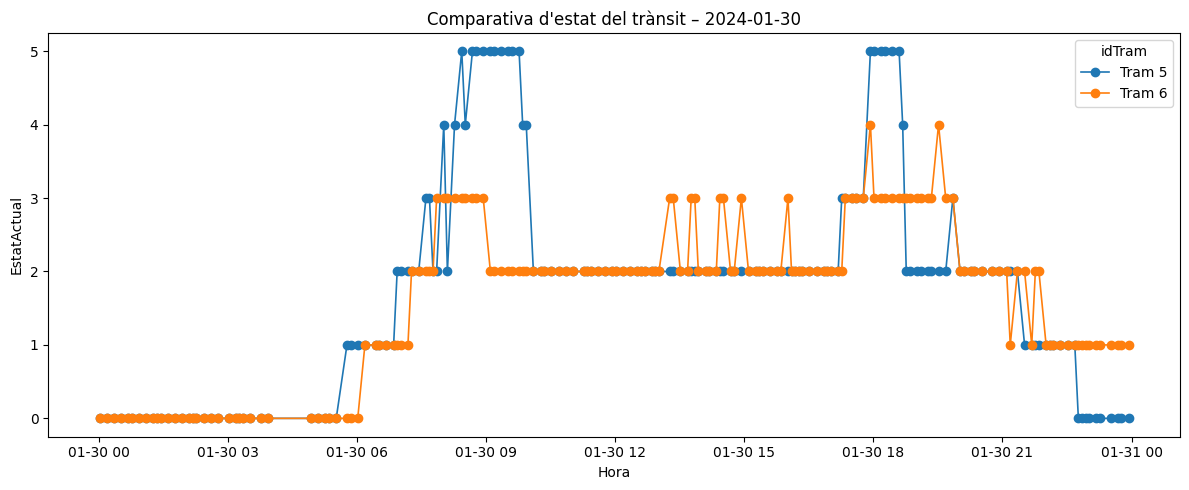

In [22]:
# ── Configura IDs i dia ─────────────────────────────
ids  = [5, 6]        # trams a comparar
dia  = "2024-01-30"    # dia d'interès (YYYY-MM-DD)

# ── Llegeix i filtra ───────────────────────────────
df = (
    pl.read_parquet("dataset_1y.parquet")
      .filter(pl.col("idTram").is_in(ids))
      .filter(pl.col("timestamp").cast(pl.Date) == pd.to_datetime(dia).date())
)

pdf = df.to_pandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])

# ── Gràfic sobreposat ──────────────────────────────
plt.figure(figsize=(12,5))
for tid in ids:
    subset = pdf[pdf["idTram"] == tid]
    plt.plot(subset["timestamp"], subset["estatActual"],
             marker="o", lw=1.2, label=f"Tram {tid}")

plt.title(f"Comparativa d'estat del trànsit – {dia}")
plt.xlabel("Hora")
plt.ylabel("EstatActual")
plt.legend(title="idTram")
plt.tight_layout()
plt.show()

/var/folders/83/gt48b8vj7tbdkb4w2zf5n42m0000gn/T/ipykernel_61108/3998475946.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = pdf["estatActual"].resample("1H").mean()


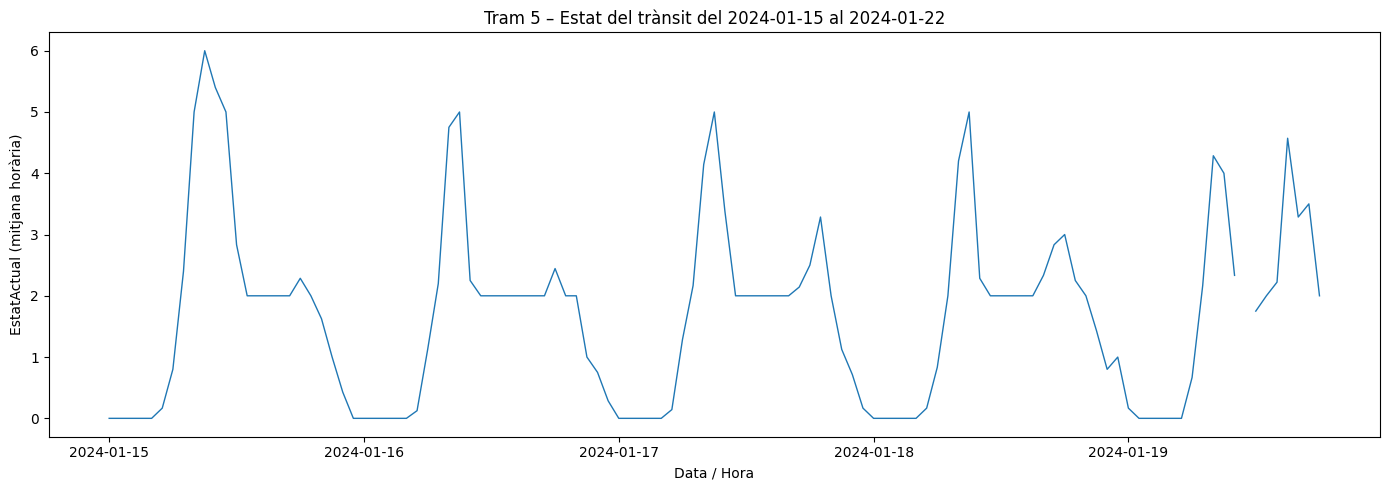

ValueError: This function does not handle missing values

In [24]:
from datetime import datetime

tram_id = 5
start   = datetime(2024, 1, 15)
end     = datetime(2024, 1, 22)

# --- Llegeix i filtra correctament ---
df = (
    pl.read_parquet("dataset_1y.parquet")
      .filter(pl.col("idTram") == tram_id)
      .filter((pl.col("timestamp") >= pl.lit(start)) &
              (pl.col("timestamp") <  pl.lit(end)))
)

pdf = df.to_pandas()
pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
pdf = pdf.set_index("timestamp")

# --- Resample a 1 hora ---
hourly = pdf["estatActual"].resample("1H").mean()

# --- Gràfic d'una setmana ---
plt.figure(figsize=(14,5))
plt.plot(hourly.index, hourly.values, lw=1)
plt.title(f"Tram {tram_id} – Estat del trànsit del {start.date()} al {end.date()}")
plt.xlabel("Data / Hora")
plt.ylabel("EstatActual (mitjana horària)")
plt.tight_layout()
plt.show()

# --- Descomposició (patró diari) ---
result = seasonal_decompose(hourly, period=24)   # 24 hores = cicle diari
result.plot()
plt.suptitle(f"Descomposició seasonal – Tram {tram_id}", y=1.02)
plt.show()
